## Time Series Analysis on Customer Churn Data


We start with loading of the libraries and creation of visual plots for the time series data.

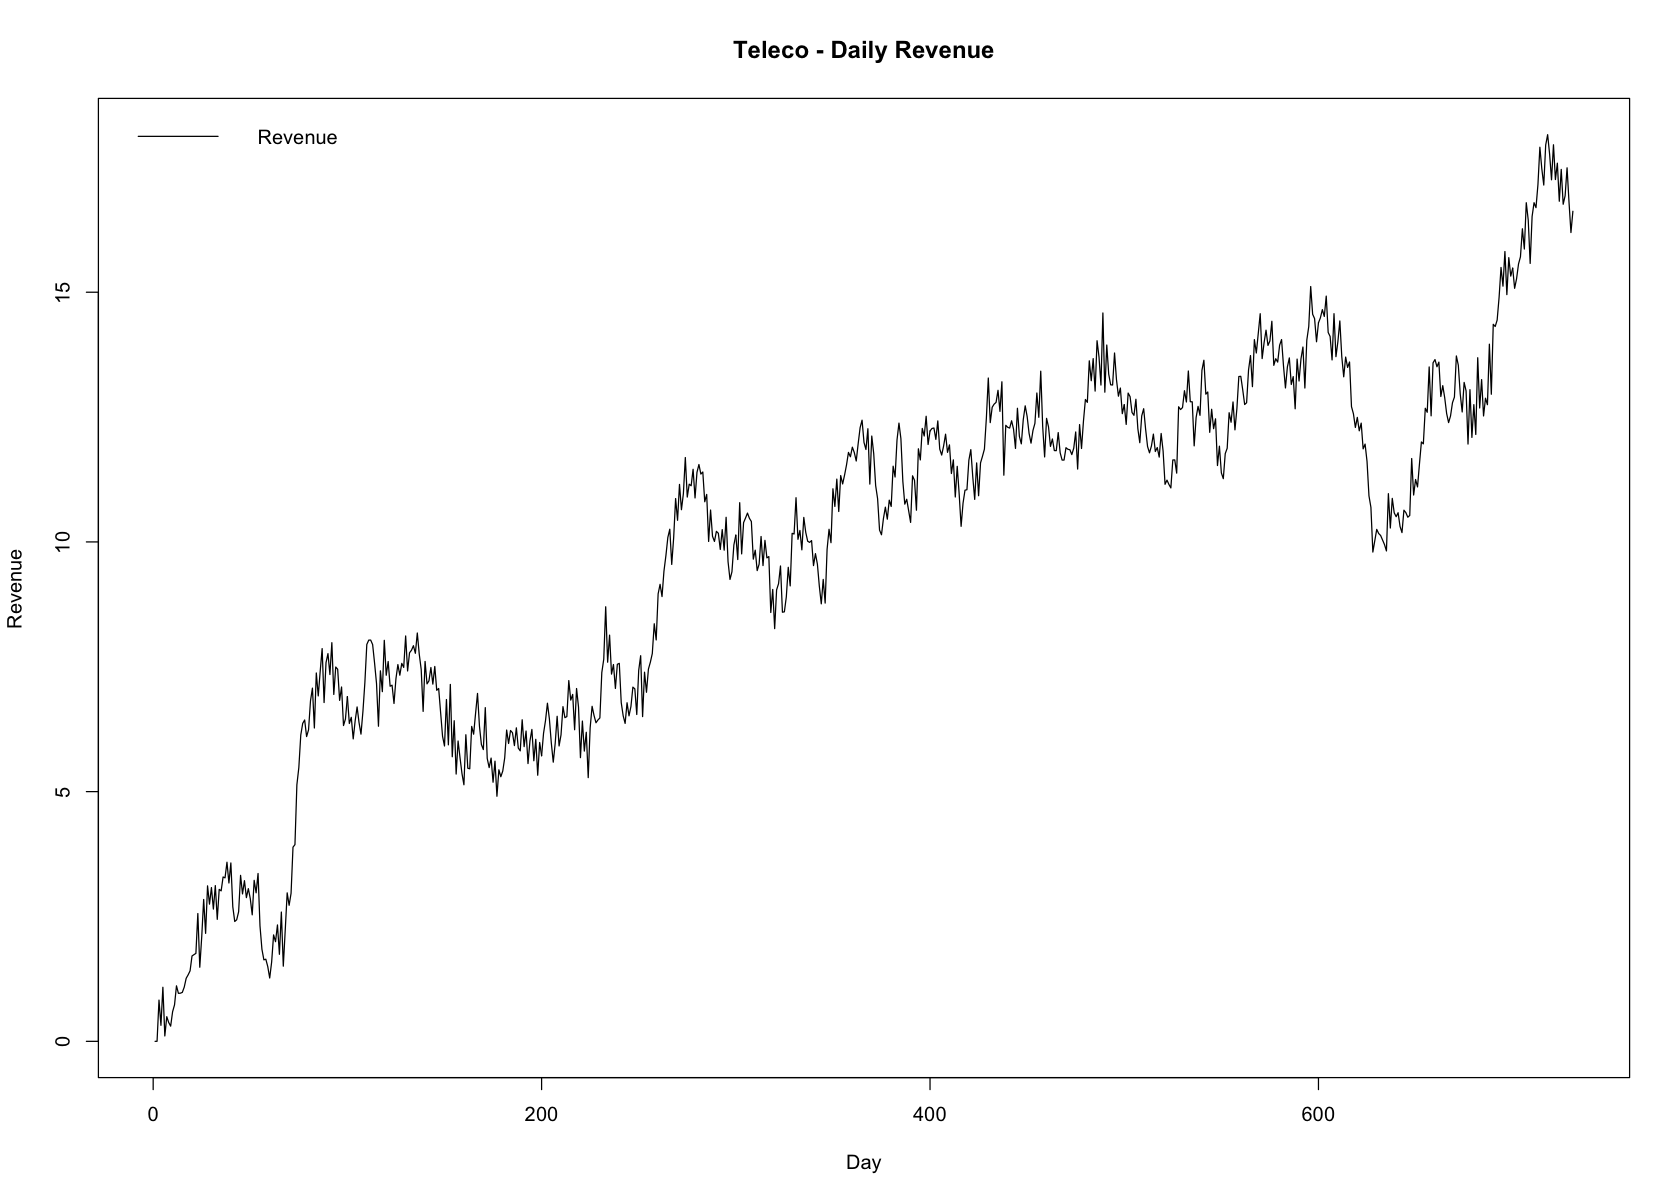

In [ ]:
# Load relevant R libraries
library('xlsx')
library('tseries')
library('astsa')
library('frequency')
library('forecast')
library('repr')

# Change plot size to 7 x 3
options(repr.plot.width=14, repr.plot.height=10)

# Read data and plot it
df <- read.csv(file = '/Users/ASHA15/Desktop/C/Learn/MS_DataAnalytics_WGU/Term3/D213_AdvancedDataAnalytics/Task1/teleco_time_series.csv')
df <- ts(df$Revenue)
ts.plot(df, xlab = "Day", ylab = "Revenue", main = "Teleco - Daily Revenue")
legend("topleft", 'Revenue', lty = 1, col = 1:1, bty = "n")

### Analyzing Teleco Revenue Data
Looking at the time series plot, it is clear the there is no seasonality in the time series. We don’t see any rising or falling repetitive trend pattern with time or days of the year. The series shows a general growth trend which also makes it non-stationary. Before time series analysis can be applied, we will have to convert it to a stationary series or apply models which implement a mechanism to make the series stationary. As you can see the series is not stationary but after applying the differencing technique it becomes a stationary series. To check the stationarity of the time series we can use the Augmented Dickey-Fuller (ADF) test (low p-value suggests stationary series) and analyze the visual trend of the difference series.


Warning message in adf.test(ddf):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ddf
Dickey-Fuller = -8.6354, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


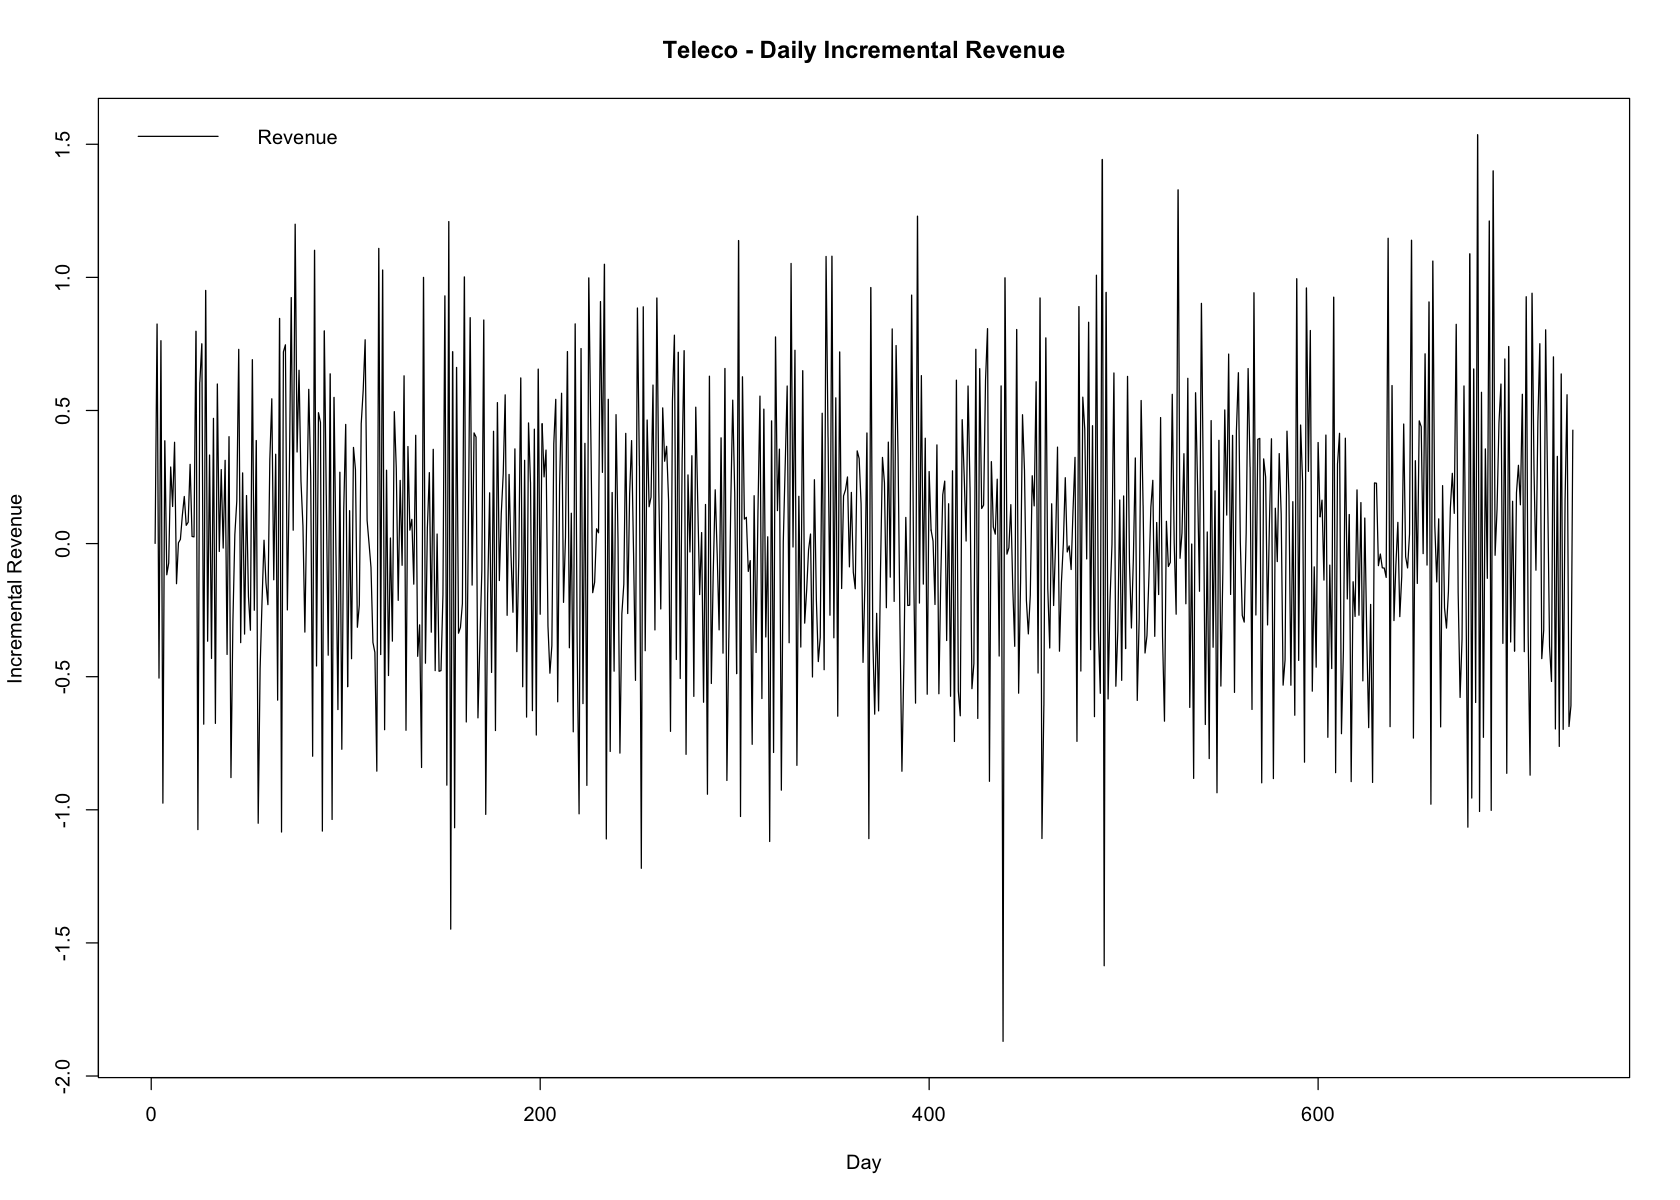

In [ ]:
# Create "difference" series, plot it and check for stationarity
ddf <- diff(df)
ts.plot(ddf, xlab = "Day", ylab = "Incremental Revenue", main = "Teleco - Daily Incremental Revenue")
legend("topleft", 'Revenue', lty = 1, col = 1:1, bty = "n")

adf.test(ddf)



#### Splitting training and testing data sets
Using simple head and tail functions, we can split the time series into training and testing sets (75% training and 25% testing). Let’s see the R code below and corresponding plots of the split sets.


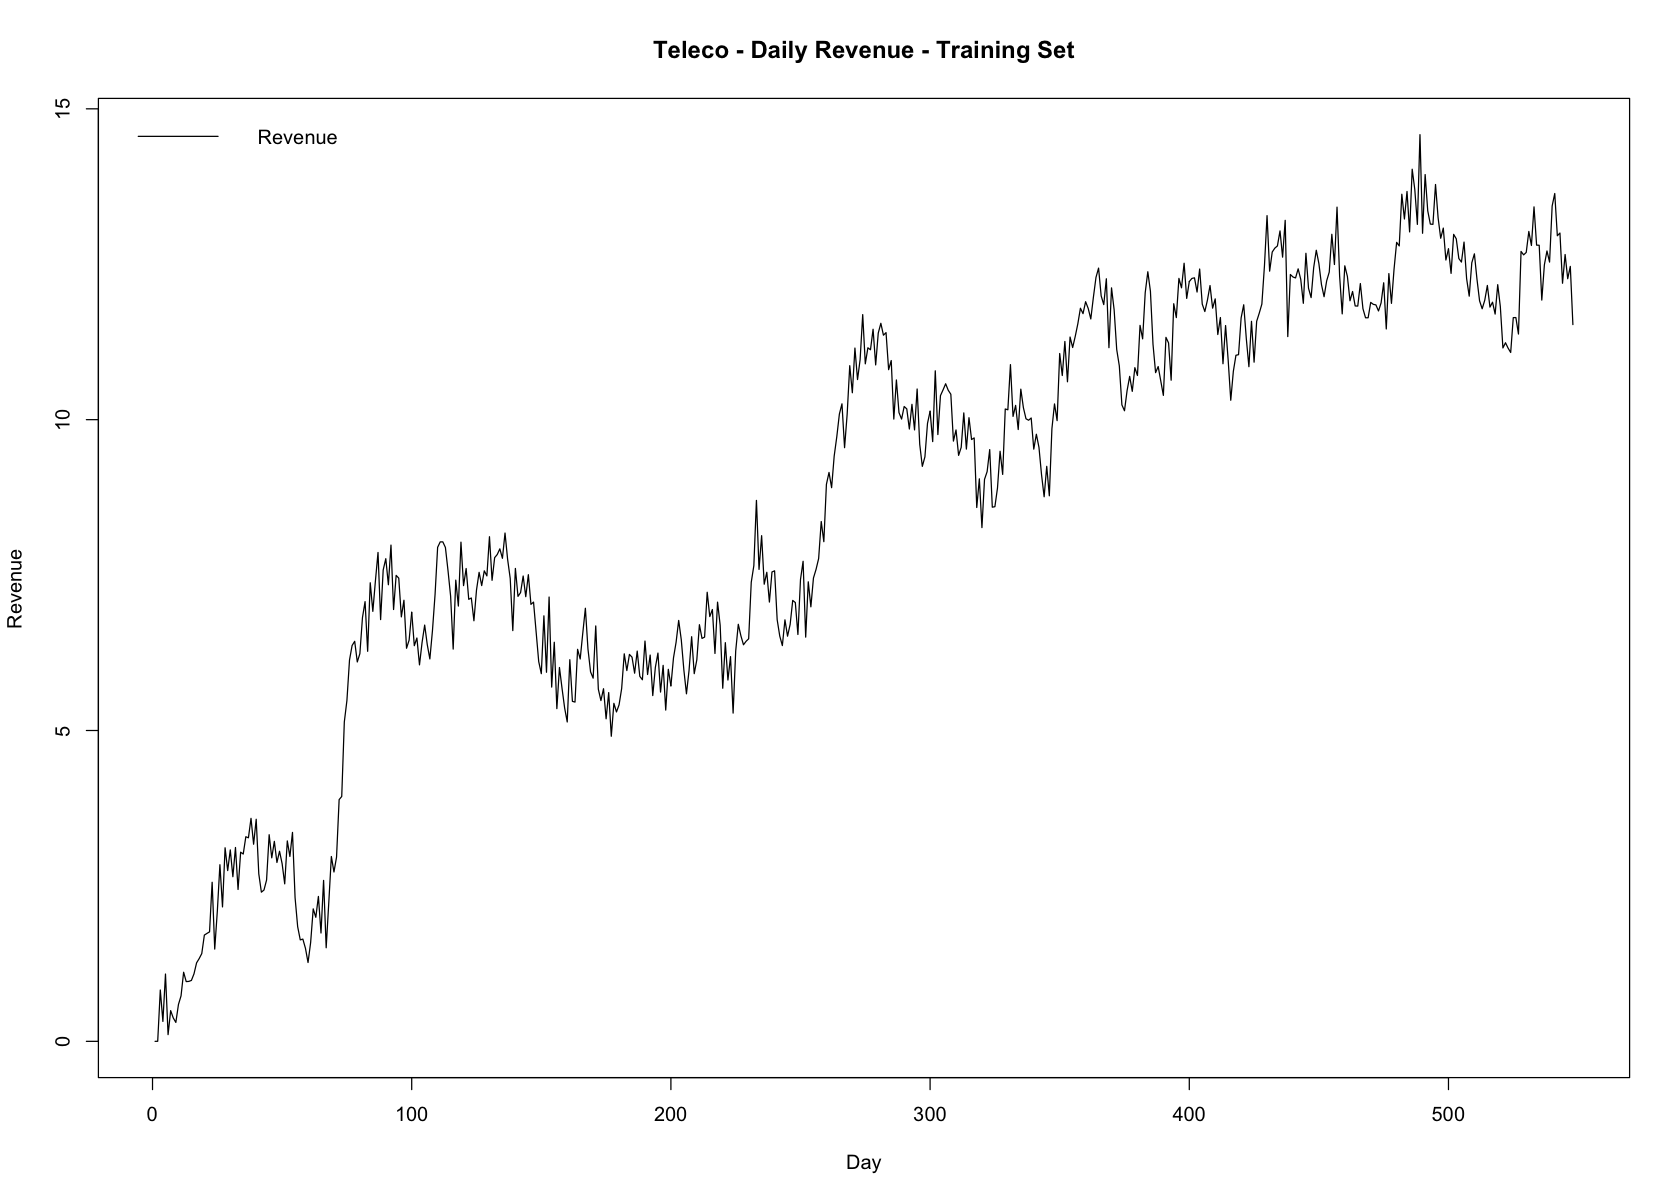

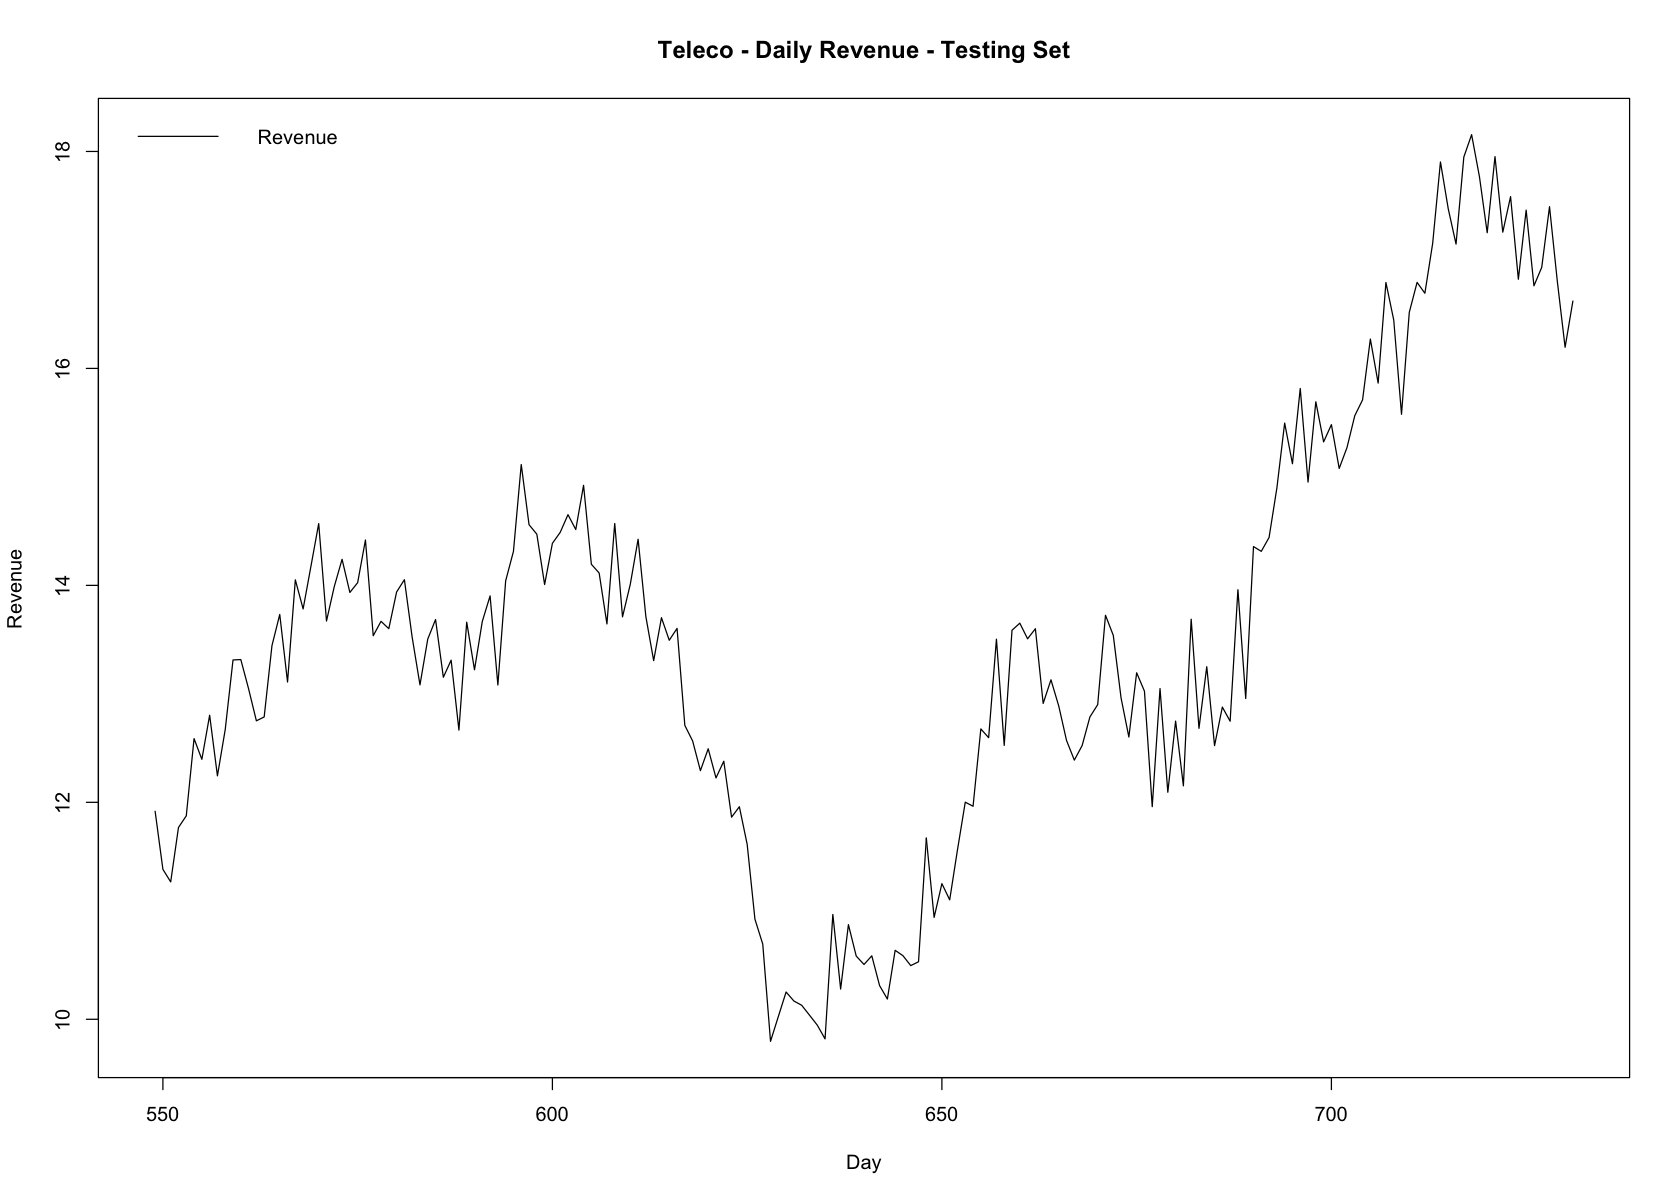

In [ ]:

# Split train and test sets and plot them

training <- head(df, round(length(df)*.75))
testing <- tail(df, round(length(df)*.25))

ts.plot(training, xlab = "Day", ylab = "Revenue", main = "Teleco - Daily Revenue - Training Set")
legend("topleft", 'Revenue', lty = 1, col = 1:1, bty = "n")

ts.plot(testing, xlab = "Day", ylab = "Revenue", main = "Teleco - Daily Revenue - Testing Set")
legend("topleft", 'Revenue', lty = 1, col = 1:1, bty = "n")



In [ ]:
# Write test and train sets to separate files
Revenue <- training
Days <- seq(1, round(length(df)*.75), by=1)
DATA <- data.frame(Days, Revenue)
write.xlsx(DATA,
    "/Users/ASHA15/Desktop/C/Learn/MS_DataAnalytics_WGU/Term3/D213_AdvancedDataAnalytics/Task1/clean_training.xlsx")

Revenue <- testing
Days <- seq(round(length(df)*.75)+1, 731, by=1)
DATA <- data.frame(Days, Revenue)
write.xlsx(DATA,
    "/Users/ASHA15/Desktop/C/Learn/MS_DataAnalytics_WGU/Term3/D213_AdvancedDataAnalytics/Task1/clean_testing.xlsx")



#### Seasonality, Tread and Irregular Components

There is a lack of seasonal component in the Revenue time series as can be seen from the plot below. There is no regular occurring seasonal pattern. The lack (or weakness) of seasonality can further be confirmed by running the decompose method of R, which breaks down the time series into different components, namely, trend, seasonal and irregular components. The function decompose results in Error as shown below.

In [ ]:
# Decompose the time series into components

dfcomponents <- decompose(df)
plot(dfcomponents)

ddfcomponents <- decompose(ddf)
plot(ddfcomponents)

decompose(diff(training))

ERROR: Error in decompose(df): time series has no or less than 2 periods


#### Spectral Density
Any time-series data can be expressed as a sum of sine and cosine functions oscillating at harmonic frequencies. A periodogram can be used to identify the dominant frequency in the data. We will plot the periodogram now using R functions.


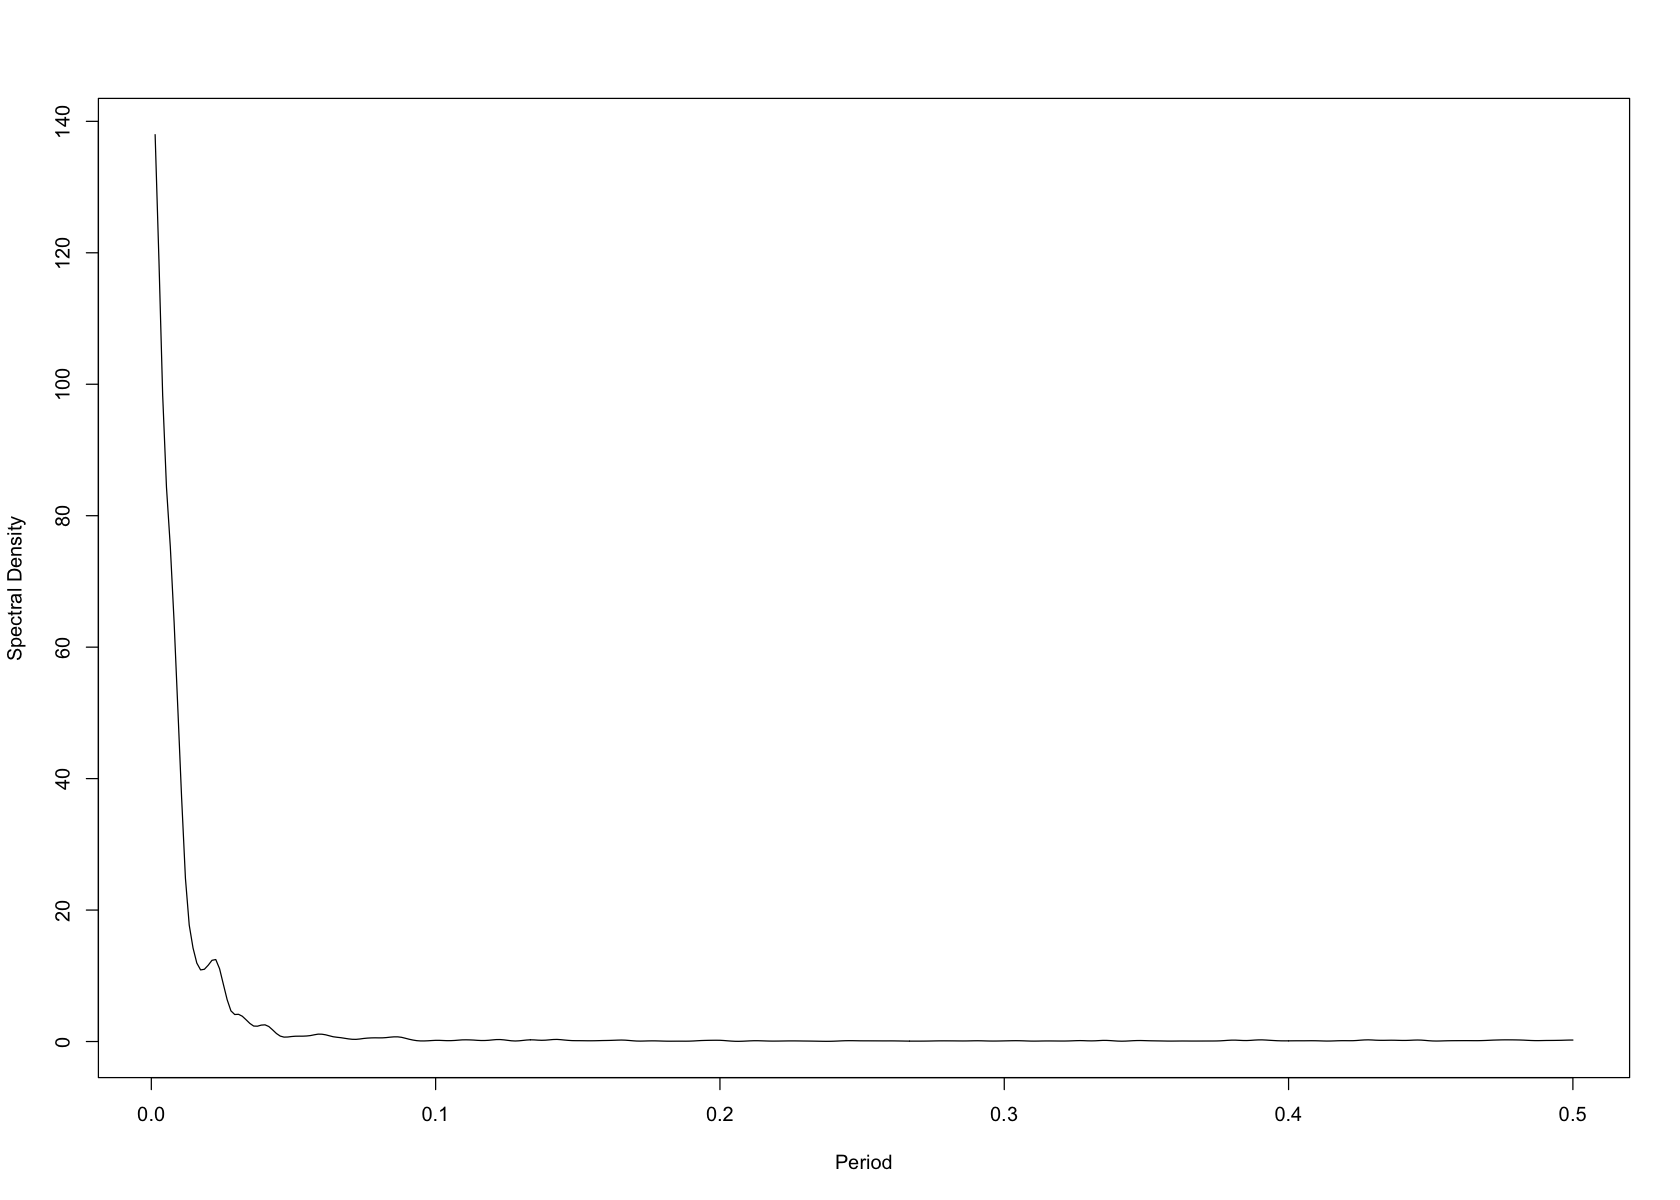

In [ ]:
# Periodogram and Spectral Density
mspect <- spectrum(df, log="no", spans=c(5,5), plot=FALSE)
specx <- mspect$freq
specy <- mspect$spec
plot(specx, specy, xlab="Period", ylab="Spectral Density", type="l")
DATA <- data.frame(specx, specy)
#print(DATA)



The peak of the plot is at the first x-axis value of 0.00133. This shows that there is no dominant frequency in the data. Value of 1/0.0013333 ~ 750 which is more than the total number of data points for 2 years (time series has no or less than 2 periods). Let’s check the periodogram of the difference series for the training set. There is no clear pattern of dominant frequency here too.

#### Autocorrelation
Autocorrelation is the correlation of data points in the data series at different points in time (lags). For example, the correlation of daily avg temperature data for each day with the previous day will be called correlation at lag 1. Correlation with each day’s data with the day before the previous day will be called correlation at lag 2. We will now check the autocorrelation function and how different lags are correlated with the data points.


ACF,-0.47,0.22,-0.06,0,0.00,-0.01,0.02,0.02,-0.03,0.03,⋯,0.03,0.01,-0.04,0.01,0.01,-0.04,0.03,0.00,-0.02,0.04
PACF,-0.47,0.01,0.06,0,-0.02,-0.01,0.02,0.04,-0.02,0.01,⋯,0.03,0.02,-0.04,-0.05,0.01,-0.03,-0.02,0.03,-0.03,0.01


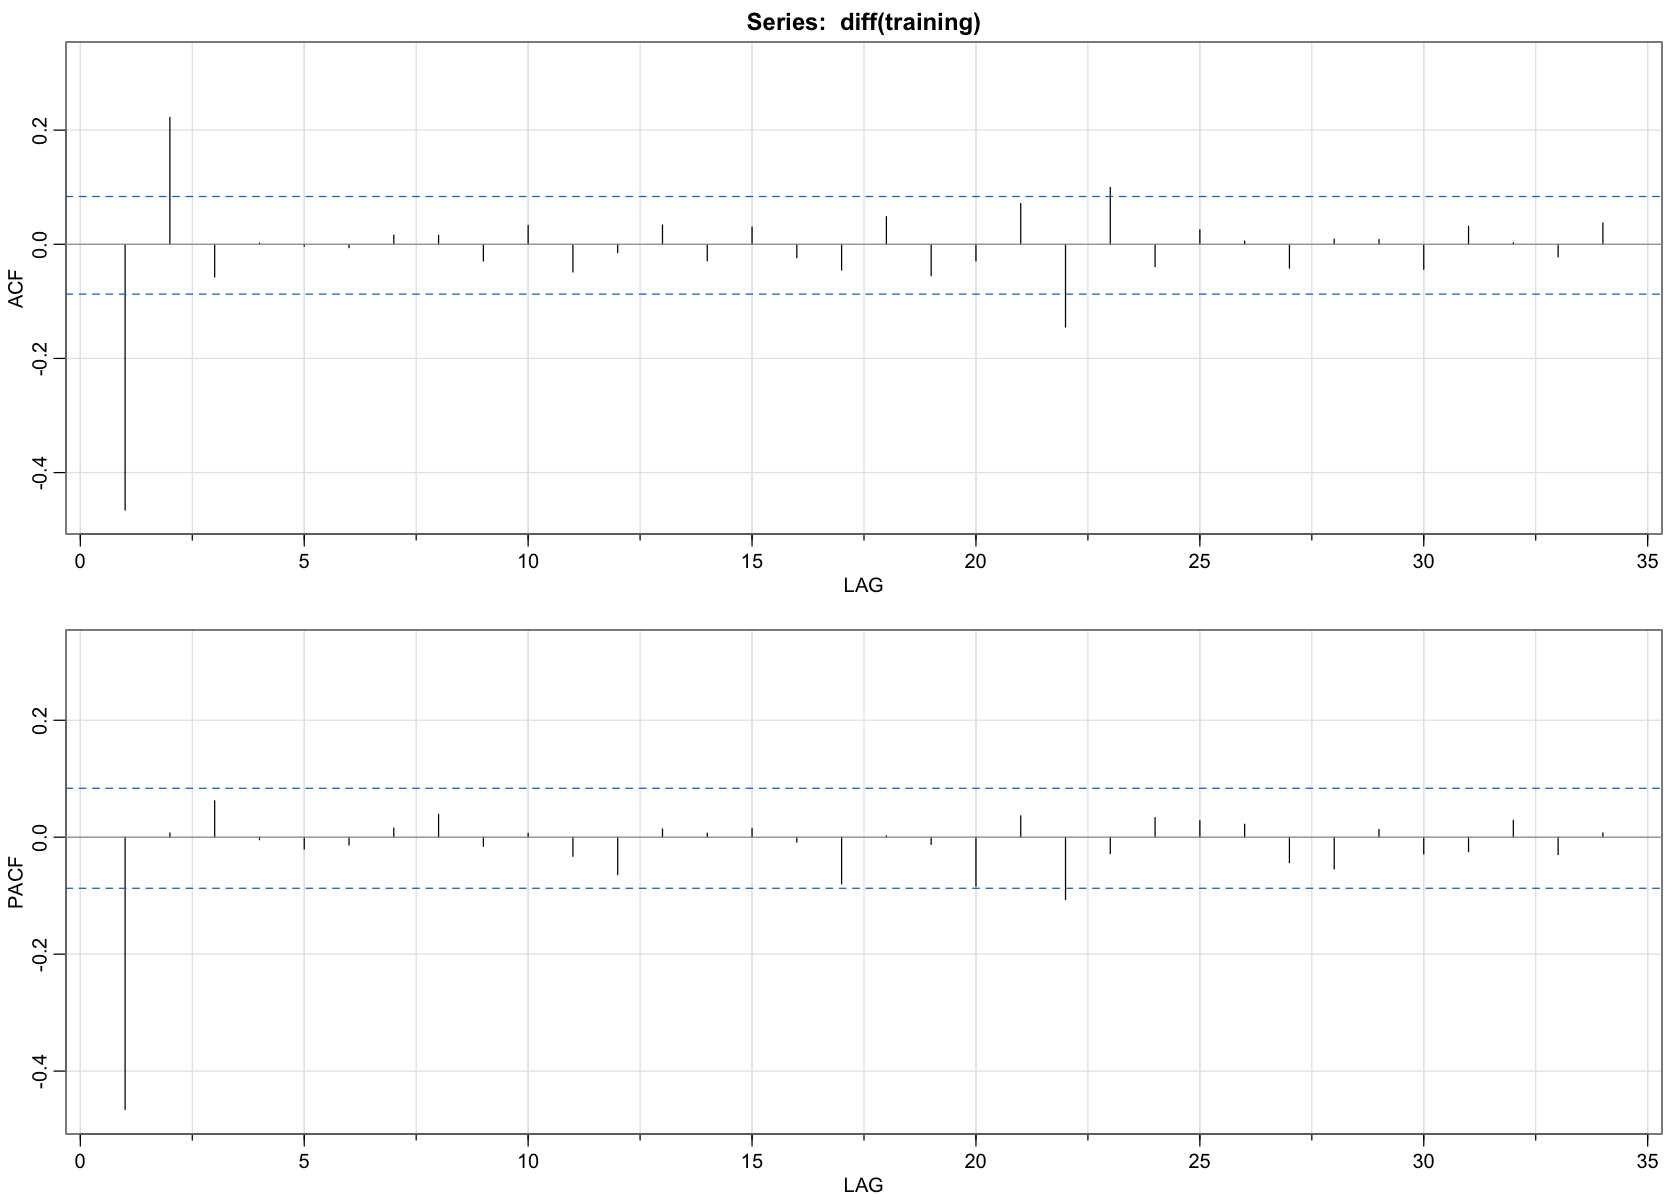

In [ ]:
# Autocorrelations
acf2(diff(training))

Autocorrelation plots show that correlation at lag 1 and 2 can be used for predictive modeling of the time series.  Correlation values at other lags are low enough not to be considered for analysis. PACF corresponds to AR term (p) and ACF corresponds to MA term (q) of the ARIMA parameters.

#### ARIMA and SARIMA Models
ARIMA stands for “autoregressive integrated moving average”. It is a statistical modeling technique sued for analyzing and forecasting time series data. The model uses a dependent relationship between data points and the data points from that some lags from immediate past data points. It makes the time series stationary by differencing technique, and it uses residual error from a moving average of the previous lagged data points. ARIMA model has 3 parameters p (lag order), d (degree of differencing), and q (order of moving average). For example, if the data is of daily average temperature change for a particular city, today’s temperature can very well correlate with temperature from yesterday or the day before that. If yesterday was a hot day, chances are that today will also be a hot day. And this correlation goes further than yesterday, for example, temperature from the day before yesterday, the day before the-day-before-yesterday and so on. How do all those values correlate with today’s temperature? Can we create a model which takes such correlations into account and enable us to predict the temperature in the coming future? ARIMA provides answers to such questions. SARIMA adds the seasonal component to ARIMA and accounts for the seasonal variation in the data.

ARIMA function has auto-regressive and Moving Average components, which corresponds to the PACF (partial autocorrelation) and ACF (autocorrelation). Based on the ACF and PACF charts above, we can choose ARIMA parameters (p=1 and q=2). However, we should fit the model and see the AIC and BIC values to makes sure this is the right model choice, and if any of the AR or MA components are not significant, we can change the model and check. An automatic suggestion of ARIMA parameters comes from “auto.arima” function in R. Let’s see the code to accomplish all that we discussed above.


In [ ]:
# ARIMA Model - Choose best model parameters
auto.arima(training, trace=TRUE)



 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : 735.5491
 ARIMA(0,1,0) with drift         : 864.6843
 ARIMA(1,1,0) with drift         : 733.1027
 ARIMA(0,1,1) with drift         : 759.36
 ARIMA(0,1,0)                    : 863.5314
 ARIMA(2,1,0) with drift         : 733.2437
 ARIMA(1,1,1) with drift         : 735.1141
 ARIMA(2,1,1) with drift         : 733.8414
 ARIMA(1,1,0)                    : 733.5782

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,1,0) with drift         : 731.0853

 Best model: ARIMA(1,1,0) with drift         



Series: training 
ARIMA(1,1,0) with drift 

Coefficients:
          ar1   drift
      -0.4676  0.0216
s.e.   0.0379  0.0137

sigma^2 estimated as 0.2211:  log likelihood=-362.52
AIC=731.04   AICc=731.09   BIC=743.95

The “auto.arima” function suggests that the best fitting model is ARIMA(1, 1, 0), instead of ARIMA(1, 1, 2) that we deduced from the ACF and PACF plots. Based on the model, we will now create the predictions and plot them against the test set to understand to check how predicted values compare with the actual values. Also, calculate MAPE for evaluation of how good the model is at predicting the revenue.

We will use SARIMA to train the model and use it for forecasting purposes. The model will also provide us with the residual analysis plots important to determine the behavior or residuals. However, as we have already chosen the model with auto.arima, we may not have to analyze multiple models to choose the best out of the lot.

initial  value -0.632470 
iter   2 value -0.755501
iter   3 value -0.755507
iter   4 value -0.755508
iter   5 value -0.755508
iter   5 value -0.755508
iter   5 value -0.755508
final  value -0.755508 
converged
initial  value -0.756195 
iter   2 value -0.756195
iter   3 value -0.756195
iter   3 value -0.756195
iter   3 value -0.756195
final  value -0.756195 
converged


$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    xreg = constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
          ar1  constant
      -0.4676    0.0216
s.e.   0.0379    0.0137

sigma^2 estimated as 0.2203:  log likelihood = -362.52,  aic = 731.04

$degrees_of_freedom
[1] 545

$ttable
         Estimate     SE  t.value p.value
ar1       -0.4676 0.0379 -12.3428  0.0000
constant   0.0216 0.0137   1.5822  0.1142

$AIC
[1] 1.336455

$AICc
[1] 1.336496

$BIC
[1] 1.360063


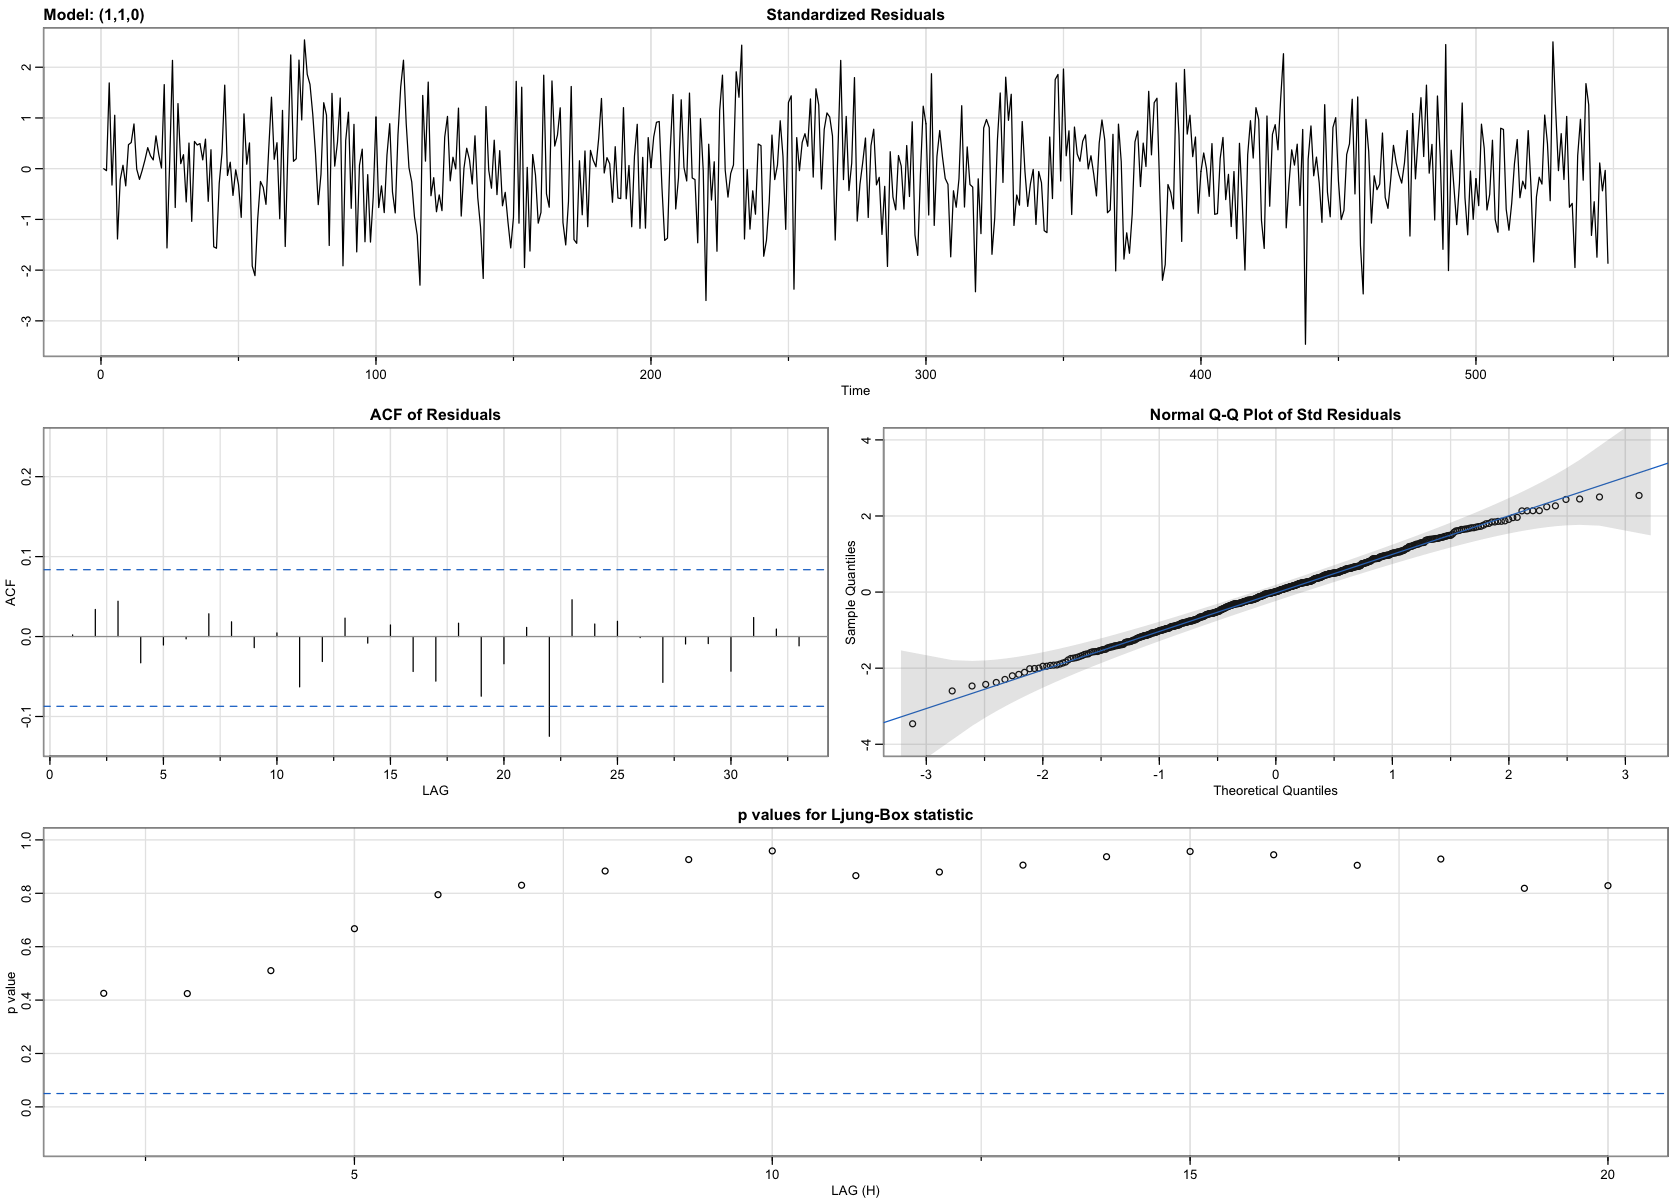

In [ ]:
# Create Predictions using SARIMA model
sarima(training, p=1, d=1, q=0)


With SARIMA model in place, now we can use it to create predictions and compare them with the actual data points from the test set. Plotting all the data points on a single plot gives a good visual comparison of the predicted vs actual values.

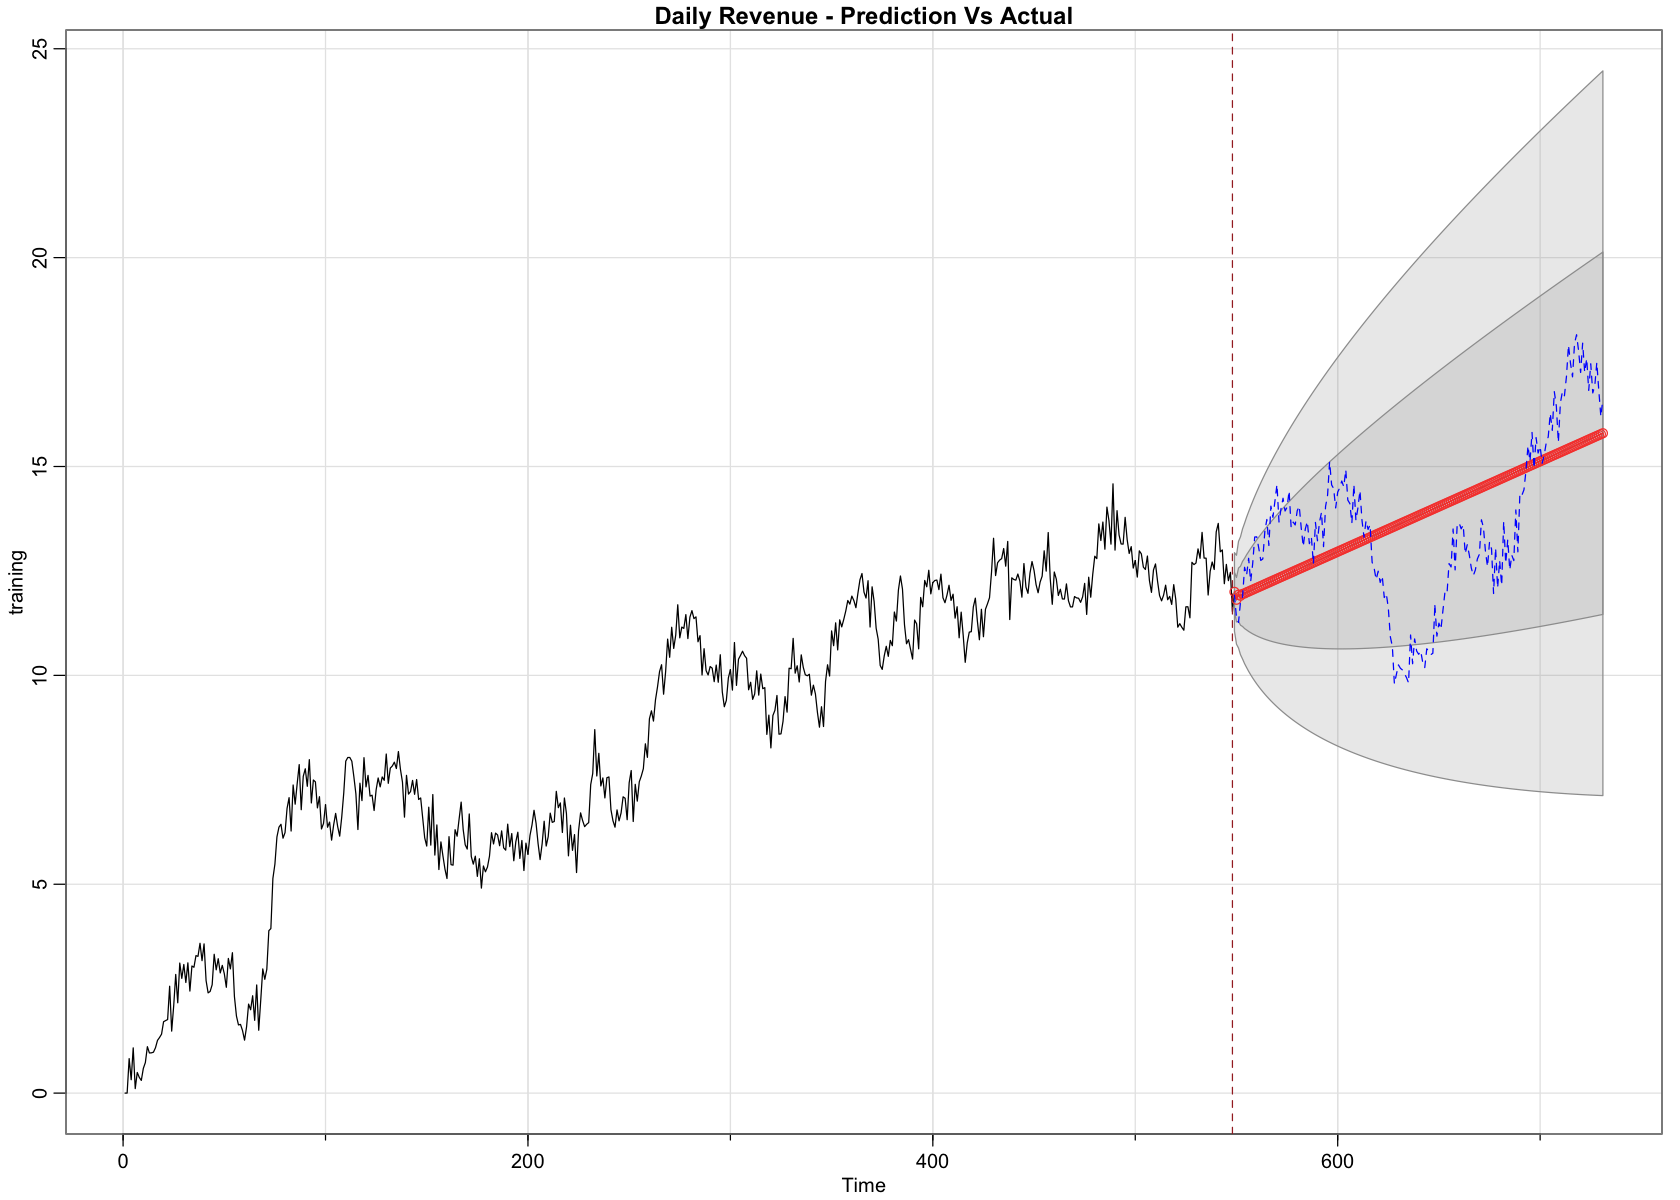

In [ ]:
pred <- sarima.for(training, n.ahead=183, p=1, d=1, q=0, plot.all=TRUE)
abline(v = ts(c(548)), col = "brown", lty = 2)
points(testing, type = "l", col = "blue" , lty = 2)
title(main="Daily Revenue - Prediction Vs Actual")


The corresponding plot for the forecast vs actual is provided below. The red points are predicted values, the blue line is the actual points from the testing data set, and the black line is the training data set.

In [ ]:
# Find MAPE (error in the predictions - Mean Absolute Percent Error)
mean(abs((testing-pred$pred)/testing)) * 100


[1] 11.82893

MAPE or mean absolute percentage error is 11.82893.

### Summary and Conclusions

As we saw in the previous sections, that starting with 731 data points from the Teleco company’s daily revenue data, we were able to create a time series model and create a forecasting mechanism for the company to predict its revenue in the future. We also compared the revenue and compared the revenue with actual data for the last 183 days of the time series to understand the quality of predictions. Let’s discuss in detail the data summary and its implications.
ARIMA model suggested that we have an autoregressive (AR) component to our predictive model while the MA or moving average component isn’t significant for modeling and forecasting. Multiple ARIMA models were compared for their AIC/BIC values and the model with the least values for AIC/BIC is chosen. AIC (Akaike Information Criterion) is the measure of goodness of the fit of the model and the lower scores are better. BIC is Bayesian Information Criteria and again smaller values are considered better. The model parameters with the smallest AIC values were found to be for p=1, q=0, and d =1.

We originally split the training and testing set as 75-25% of the original 2-year data. This means that we used data worth 1 and ½ years for modeling and data for the last ½ year for testing the predictions from the predictive model. The data didn’t exhibit any strong seasonal patterns. The absence of seasonal patterns didn’t require additional analysis on prediction interval the data we used for predictions remained at a per day level. Predictions were done for a period of 183 days corresponding to the number of points in the testing set so that the predicted values and the test set values can be compared.

Sigma square value of the SARIMA model is 0.2203 which represents the variance of the residual values. MAPE or mean absolute percentage error value for the predictive model is 11.82893 which means that the average difference between the predicted and actual value is ~12%. So, using this predictive model, we can predict the daily revenue of the Teleco company with a ~12% error rate. This is a fairly accurate model, and it can give great insight into how the company will perform for several months in the future on a daily revenue basis.

Provided below is a final plot with all the details. It includes the training set, testing set, values from the SARIMA, and linear predictive model (for comparison purposes).

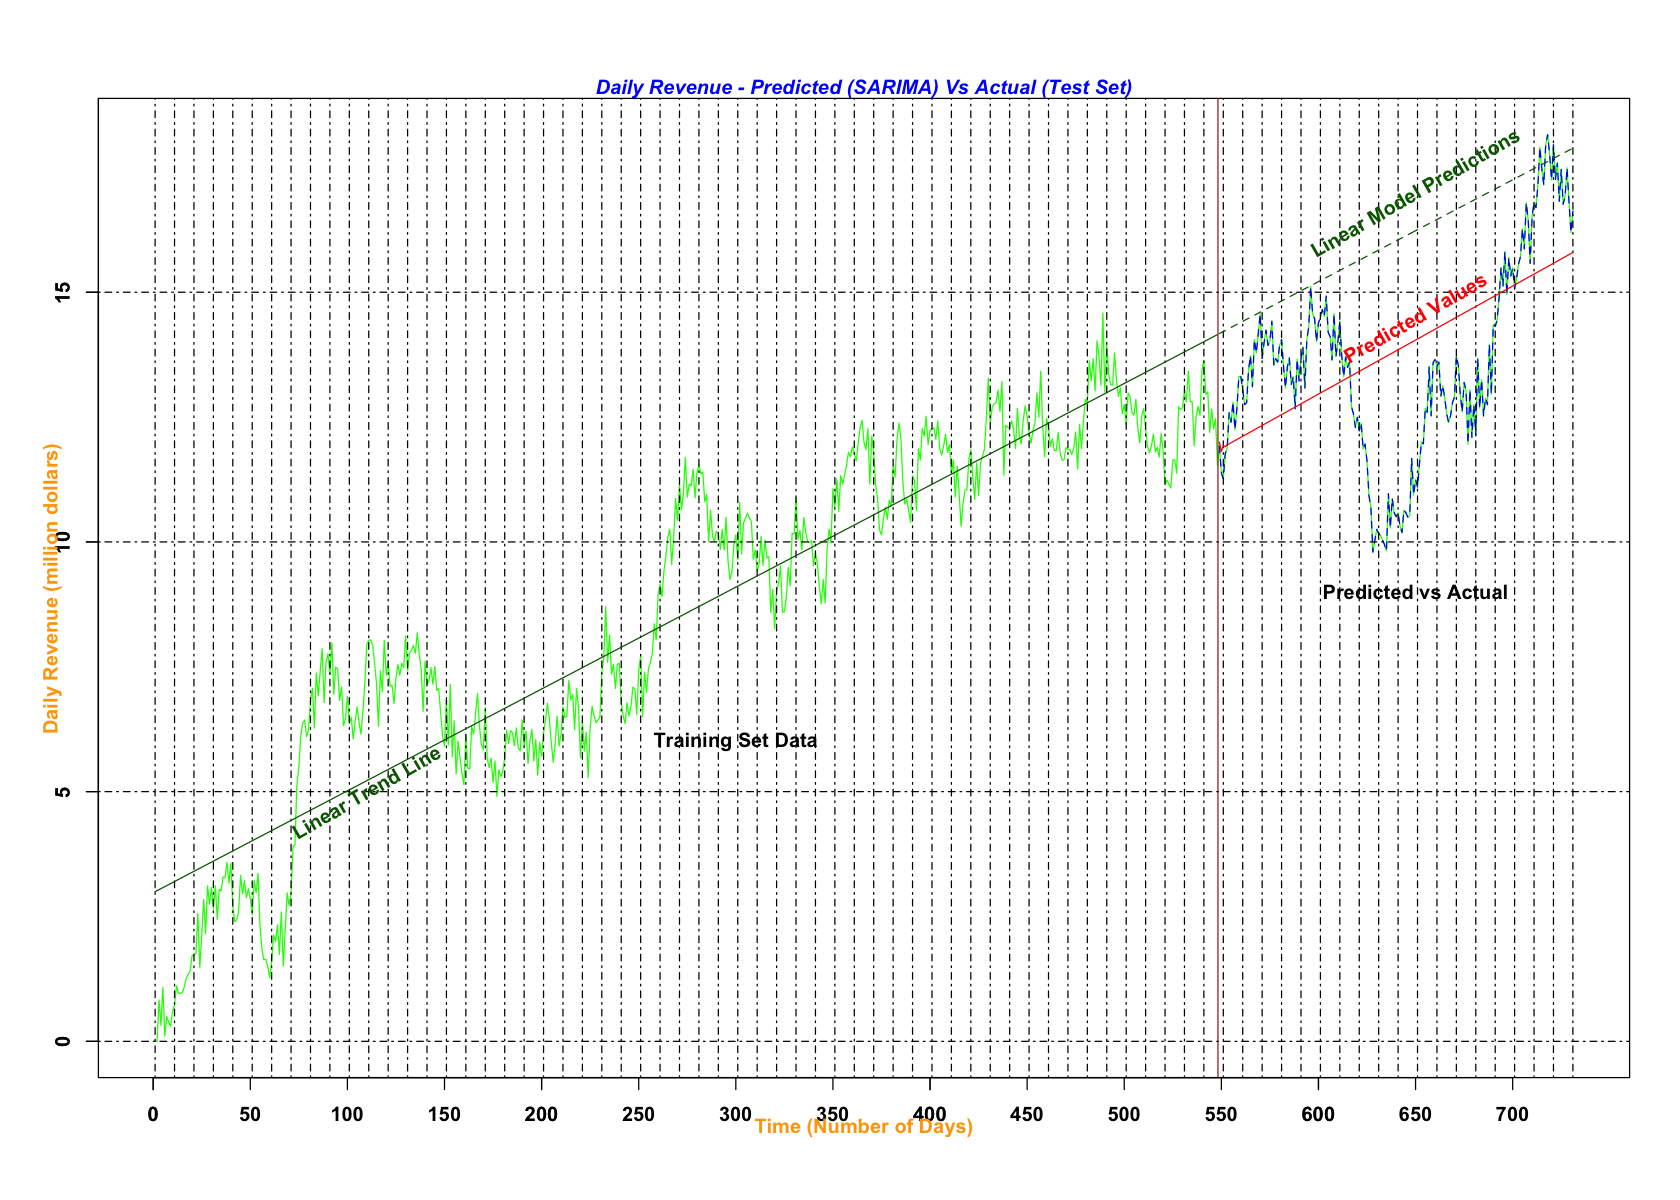

In [ ]:
# Create final chart with annotations and various components
plot(df, main="", xlab="", ylab="", col = 'green')
points(testing, type = "l", col = "blue" , lty = 2)
abline(v = ts(c(length(df)*0.75)), col = "brown")
abline(v = ts(seq(1, 731, 10)), col = "black", lty = 1000)
abline(h=seq(0, 20, 5), col="black", lty = 1000)
points(pred$pred, type = "l", col = "red" )
x <- seq(1, 548, 1)
lmod <- lm(c(training)~x)
lines(predict(lmod),col='darkgreen')
lpred <- predict(lmod, newdata = data.frame(x = seq(549, 731, 1)))
points(y=lpred,x=seq(549,731,1),type='l',col = "darkgreen" , lty = 2)

axis(1, seq(0,731,50), font=2)
axis(2, seq(0,20,5), font=2)
mtext(side=1, line=1.5, "Time (Number of Days)", col="orange", font=2)
mtext(side=2, line=1.5, "Daily Revenue (million dollars)", col="orange", font=2)
mtext(side=3, line=0, "Daily Revenue - Predicted (SARIMA) Vs Actual (Test Set)", col="blue", font=4)
text(x=650, y=9, labels="Predicted vs Actual", font=2)
text(x=300, y=6, labels="Training Set Data", font=2)
text(x=650,y=14.5,"Predicted Values",srt=30, col="red", font=2)
text(x=650,y=17,"Linear Model Predictions",srt=30, col="darkgreen", font=2)
text(x=110,y=5,"Linear Trend Line",srt=30, col="darkgreen", font=2)




#### Further Action

For the company executives, an accurate predictive model of revenue is important to assess the overall health of the business. If the revenue is going down, executives can take corrective measures, and investigate the root cause of the factors leading to a decline in revenue. If the revenue is growing, it is expected to bring in more demand for the company’s products and services. To keep up with the demand, company executives will have to plan and optimize production capacity, supply chain management, human resources, and market factors impacting sales and revenue. Time series modeling can help create such a predictive model, providing the company executives deep insight into how the company is performing and how will it perform in the upcoming future.

The data made available for analysis was from the first 2 years of the company’s revenue. However, analysis of the revenue trend over a longer period can help understand the patterns better. It would be good to get access to more data and analyze further trends. There was an absence of seasonality in the data. So, it shows that there aren’t factors in play that impact the revenue down periodically, say, a drop in revenue during winter months or January. Such patterns don’t exist in the data provided for analysis. If the months and date information is available for this data (instead of just the day number), the data can be summarized at a monthly level and more trends in the data can be analyzed for further insights into monthly performances of the company’s revenue.

There is an overall growth trend in the time series. A simple linear model tells us there is an overall growth of revenue at the rate of 0.02039 million dollars per day. Comparison with linear model shows that time series SARIMA model is much more accurate at predicting the revenue.
